## Imports and Preliminaries

In [2]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset
from scipy.spatial.distance import cosine
from difflib import SequenceMatcher

sns.set_style("whitegrid")


def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Similarity Metric Functions

In [1]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 / (1 + np.linalg.norm(v1 - v2))

def cosine_sim(v1, v2):
    """Calculate cosine similarity."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return 1 - cosine(v1, v2)

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets or arrays."""
    a, b = np.asarray(set1).ravel(), np.asarray(set2).ravel()
    a, b = set(a.tolist()), set(b.tolist())
    intersection = len(a & b)
    union = len(a | b)
    return intersection / union if union != 0 else 0

def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient."""
    v1, v2 = np.asarray(v1).flatten(), np.asarray(v2).flatten()
    return np.corrcoef(v1, v2)[0, 1]

def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher."""
    str1, str2 = str(str1), str(str2)
    return SequenceMatcher(None, str1, str2).ratio()


## PCA tensor mapping

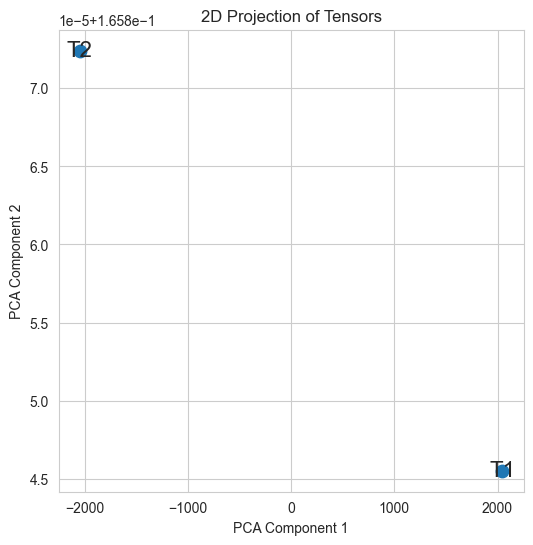

In [4]:
from sklearn.decomposition import PCA

def plot_tensors_2d(*tensors):
    """
    Takes n tensors of arbitrary dimensionality, flattens them, reduces to 2D using PCA,
    and plots them on a 2D scatter plot.
    """
    # Flatten each tensor into a 1D vector
    flattened = [t.reshape(-1) for t in tensors]
    
    # Stack into a single matrix (n_samples x n_features)
    data = np.stack(flattened)
    
    # Reduce to 2D with PCA
    reduced = PCA(n_components=2).fit_transform(data)
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=80)
    for i, (x, y) in enumerate(reduced):
        plt.text(x, y, f'T{i+1}', fontsize=16, ha='center', va='center')
    plt.title("2D Projection of Tensors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

a = torch.randn(128, 256, 256)
b = torch.randn(128, 256, 256)

plot_tensors_2d(a.numpy(), b.numpy())


## Dataset Class

In [48]:
from pathlib import Path
from PIL import Image
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        """
        Args:
            root_dir: Path to MVTec AD dataset root
            category: Product category (e.g., 'bottle', 'cable', 'capsule')
            split: 'train' or 'test'
            transform: Preprocessing transforms
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        
        # Build image paths
        self.image_paths = []
        self.labels = []
        self.defect_types = []
        
        if split == 'train':
            # Training images are all normal
            train_dir = self.root_dir / category / 'train' / 'good'
            for img_path in sorted(train_dir.glob('*.png')):
                self.image_paths.append(img_path)
                self.labels.append(0)
                self.defect_types.append('good')
        else:
            # Test images include normal and anomalies
            test_dir = self.root_dir / category / 'test'
            for defect_dir in sorted(test_dir.iterdir()):
                if defect_dir.is_dir():
                    defect_type = defect_dir.name
                    label = 0 if defect_type == 'good' else 1
                    for img_path in sorted(defect_dir.glob('*.png')):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                        self.defect_types.append(defect_type)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.defect_types[idx]


## Create Datasets

In [49]:
from torch.utils.data import ConcatDataset

MVTEC_ROOT = './Dataset' 
CATEGORY = 'cable'
BATCH_SIZE = 16
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ])


transform = get_transforms(IMAGE_SIZE)

all_categories = [
    'bottle', 'cable', 'capsule', 'carpet', 'grid', 'hazelnut',
    'leather', 'metal_nut', 'pill', 'screw', 'tile',
    'toothbrush', 'transistor', 'wood', 'zipper'
]

train_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="train", transform=transform)
    for cat in all_categories
]

train_dataset = ConcatDataset(train_datasets)

test_datasets = [
    MVTecDataset(root_dir=MVTEC_ROOT, category=cat, split="test", transform=transform)
    for cat in all_categories
]

test_dataset = ConcatDataset(test_datasets)


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
)

TRAINING IMAGES


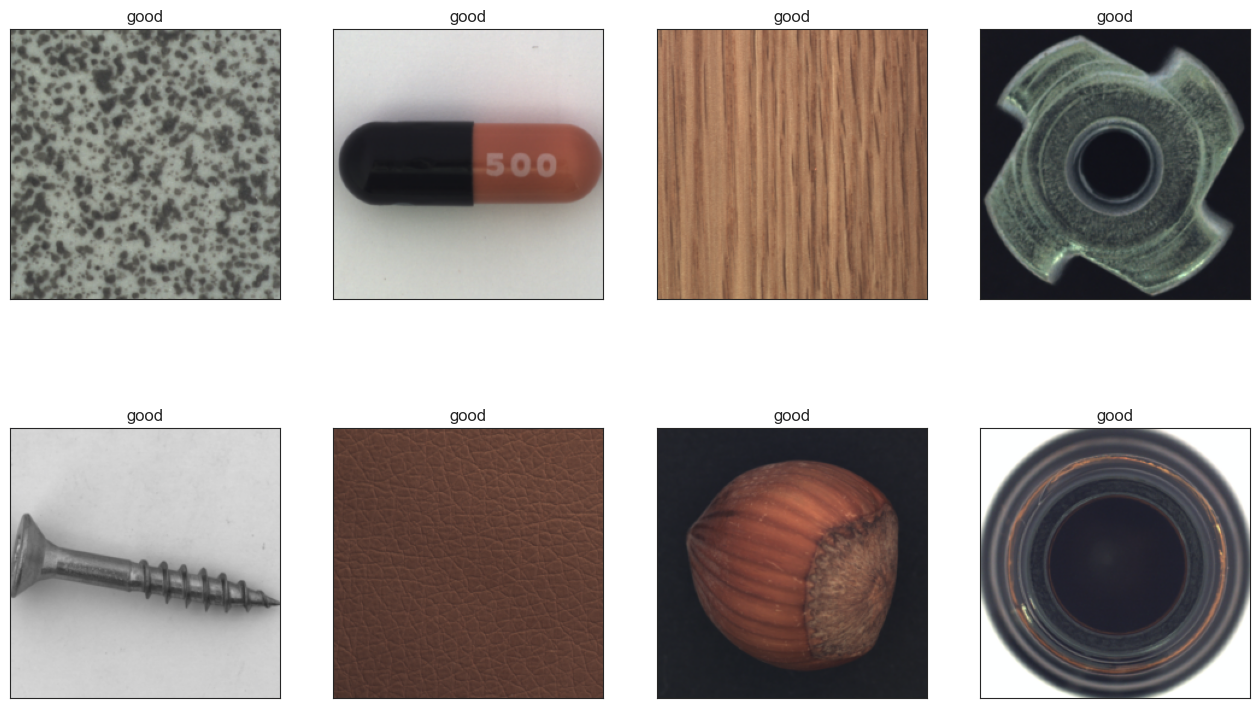

TESTING IMAGES


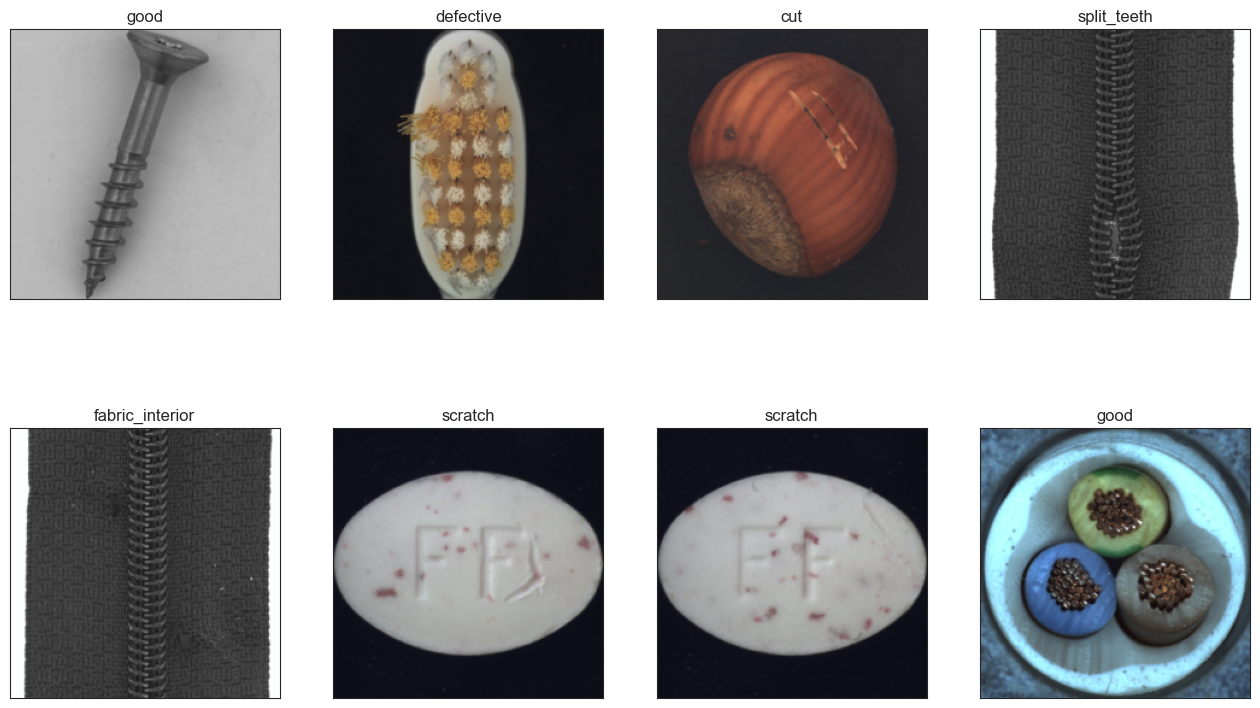

In [50]:

def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:8], labels[:8])):
        plt.sca(axes[j])
        show_image(img, label)
    plt.show()

print("TRAINING IMAGES")
show_dataset_examples(train_loader)
print("TESTING IMAGES")
show_dataset_examples(test_loader)